In [1]:
import cks.initialize as initialize
import cks.evolve as evolve
import pylab as pl
import arrayfire as af
import params
af.set_backend("cpu")

% matplotlib inline

In [2]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['figure.dpi']      = 300
pl.rcParams['image.cmap']      = 'jet'
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in' 

In [3]:
config = initialize.set(params)

In [4]:
x     = initialize.calculate_x(config)
vel_x = initialize.calculate_vel_x(config)
y     = initialize.calculate_y(config)
vel_y = initialize.calculate_vel_y(config)

In [5]:
f_initial  = initialize.f_initial(config)
time_array = initialize.time_array(config)

In [6]:
class args:
    pass

args.config = config
args.f      = f_initial
args.vel_x  = vel_x
args.vel_y  = vel_y
args.x      = x
args.y      = y

In [7]:
data, f_final = evolve.time_integration(args, time_array)

Computing for Time =  0.01
Computing for Time =  0.11
Computing for Time =  0.21
Computing for Time =  0.31
Computing for Time =  0.41


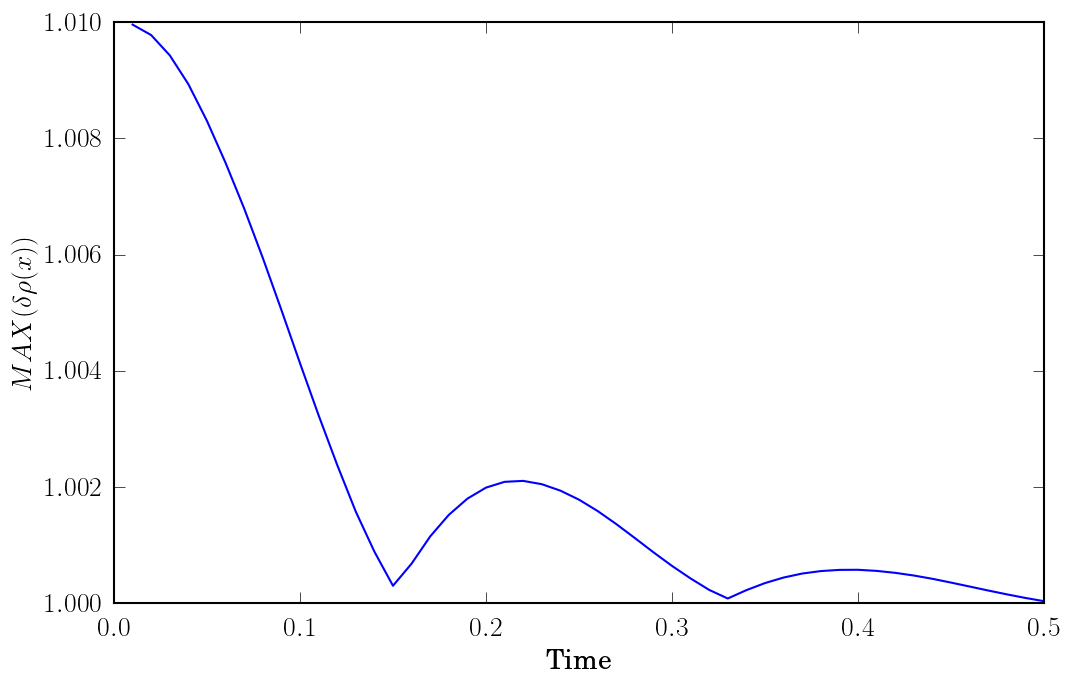

In [8]:
pl.plot(time_array, data)
pl.xlabel('Time')
pl.ylabel(r'$MAX(\delta \rho(x))$')